In [ ]:
pip install lime

In [ ]:
pip install shap


In [3]:
from skimage.feature import hog
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np

# Function to load and preprocess images from folders
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, label_folder in enumerate(['Bengin cases', 'Malignant cases', 'Normal cases']):
        path = os.path.join(folder, label_folder)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = io.imread(img_path, as_gray=True)  # Read images as grayscale
            if img is not None:
                img = transform.resize(img, (100, 100))  # Resize images to a consistent size
                images.append(img)
                labels.append(label)  # Assigning labels based on folder names
    return images, labels

# Load images and labels
data_folder = '/content/drive/MyDrive/lung-model/Data/The IQ-OTHNCCD lung cancer dataset'  # Replace this with data folder path
images, labels = load_images_from_folder(data_folder)

# Convert images to HOG features
hog_features = []
for image in images:
    # Extract HOG features
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    hog_features.append(features)

# Convert the lists to numpy arrays
X = np.array(hog_features)
y = np.array(labels)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # adjust the number of trees (n_estimators) and other parameters here

# Training the model
random_forest_classifier.fit(X_train, y_train)

# Predicting on the test set
predictions = random_forest_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Getting detailed metrics
print(classification_report(y_test, predictions))

Accuracy: 0.97
              precision    recall  f1-score   support

           0       1.00      0.59      0.74        22
           1       0.98      1.00      0.99       261
           2       0.96      0.98      0.97       132

    accuracy                           0.97       415
   macro avg       0.98      0.86      0.90       415
weighted avg       0.97      0.97      0.97       415



In [6]:
# Plot Confusion Matrix
def plot_confusion_matrix(y_test, predictions, class_names):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Plot Classification Report as a Heatmap
def plot_classification_report(y_test, predictions, class_names):
    report = classification_report(y_test, predictions, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
    plt.title("Classification Report")
    plt.show()

# Plot Feature Importance
def plot_feature_importance(model, num_features=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-num_features:]  # Get indices of the top features

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    plt.title("Top Feature Importances in Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature Index")
    plt.show()

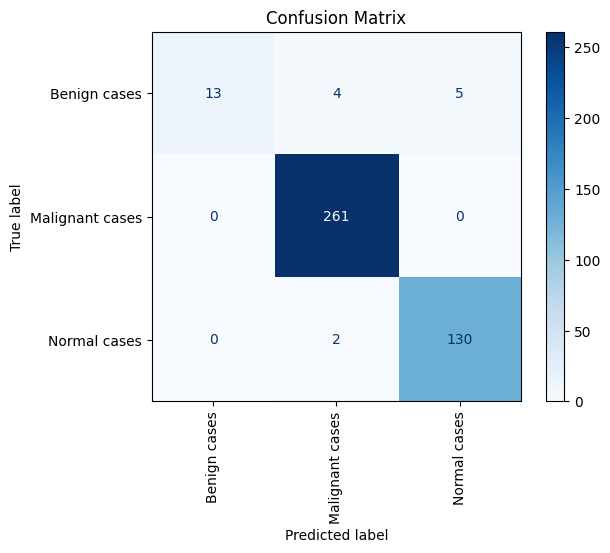

In [8]:
# Define class names
class_names = ['Benign cases', 'Malignant cases', 'Normal cases']

# Plotting confusion matrix
plot_confusion_matrix(y_test, predictions, class_names)



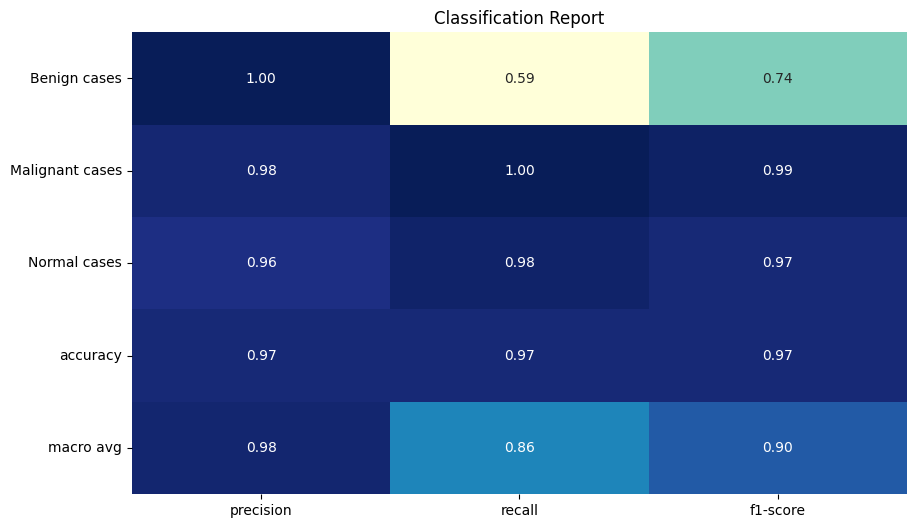

In [9]:
# Plotting classification report heatmap
plot_classification_report(y_test, predictions, class_names)



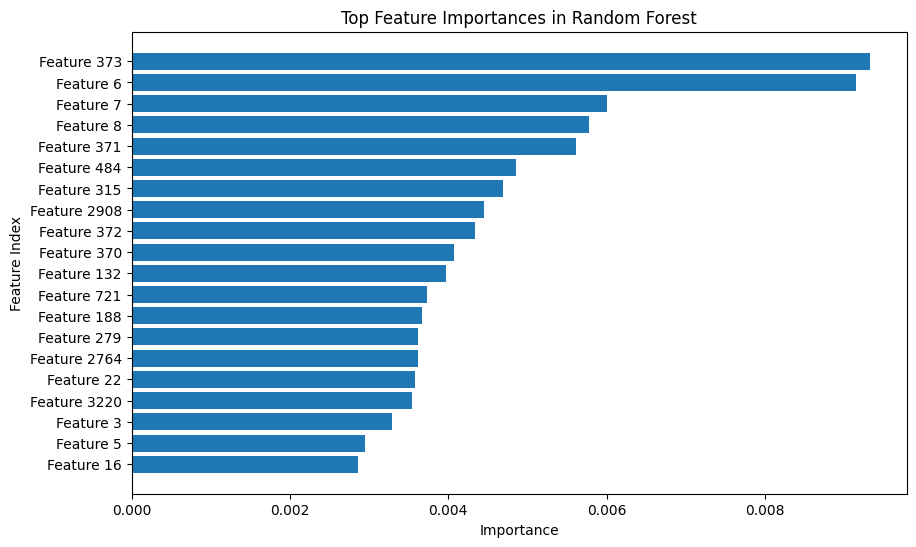

In [10]:
# Plotting feature importance
plot_feature_importance(random_forest_classifier)

In [11]:
# Plot Feature Importance
def plot_feature_importance(model, num_features=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-num_features:]  # Get indices of the top features

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    plt.title("Top Feature Importances in Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature Index")
    plt.show()

In [14]:
# Plot ROC Curve and AUC
def plot_roc_auc(y_test, probabilities, class_names):
    # Binarize the labels
    y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
    n_classes = y_test_binarized.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), probabilities.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(class_names[i], roc_auc[i]))

    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
             label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define class names
class_names = ['Benign cases', 'Malignant cases', 'Normal cases']



# Plotting ROC-AUC
plot_roc_auc(y_test, probabilities, class_names)

NameError: name 'probabilities' is not defined

In [ ]:
from skimage.feature import hog
from skimage import io, color, transform
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np

# Function to load and preprocess images from folders
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, label_folder in enumerate(['/content/drive/MyDrive/transfer-learning-covid-19-vgg19/1NonCOVID', '/content/drive/MyDrive/transfer-learning-covid-19-vgg19/2COVID', '/content/drive/MyDrive/transfer-learning-covid-19-vgg19/3CAP']):
        path = os.path.join(folder, label_folder)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = io.imread(img_path, as_gray=True)  # Read images as grayscale
            if img is not None:
                img = transform.resize(img, (100, 100))  # Resize images to a consistent size
                images.append(img)
                labels.append(label)  # Assigning labels based on folder names
    return images, labels

# Load images and labels
data_folder = '/content/drive/MyDrive/transfer-learning-covid-19-vgg19/.ipynb_checkpoints'  # Replace this with data folder path
images, labels = load_images_from_folder(data_folder)

# Convert images to HOG features
hog_features = []
for image in images:
    # Extract HOG features
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    hog_features.append(features)

# Convert the lists to numpy arrays
X = np.array(hog_features)
y = np.array(labels)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # adjust the number of trees (n_estimators) and other parameters here

# Training the model
random_forest_classifier.fit(X_train, y_train)

# Predicting on the test set
predictions = random_forest_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Getting detailed metrics
print(classification_report(y_test, predictions))



Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1395
           1       0.94      0.91      0.93      1514
           2       1.00      0.96      0.98       525

    accuracy                           0.94      3434
   macro avg       0.95      0.94      0.95      3434
weighted avg       0.94      0.94      0.94      3434



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Plot Confusion Matrix
def plot_confusion_matrix(y_test, predictions, class_names):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Plot Classification Report as a Heatmap
def plot_classification_report(y_test, predictions, class_names):
    report = classification_report(y_test, predictions, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
    plt.title("Classification Report")
    plt.show()

# Plot Feature Importance
def plot_feature_importance(model, num_features=20):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-num_features:]  # Get indices of the top features

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
    plt.title("Top Feature Importances in Random Forest")
    plt.xlabel("Importance")
    plt.ylabel("Feature Index")
    plt.show()




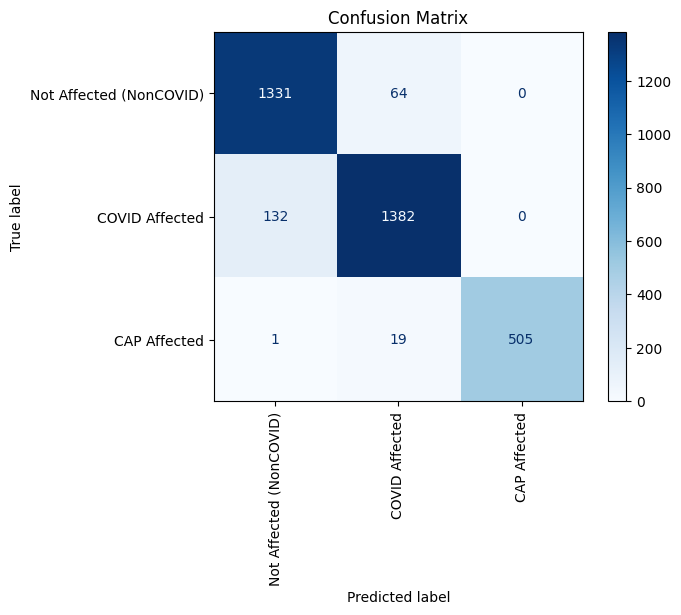

In [ ]:
# Visualize Model Performance
plot_confusion_matrix( y_test, predictions, class_names)


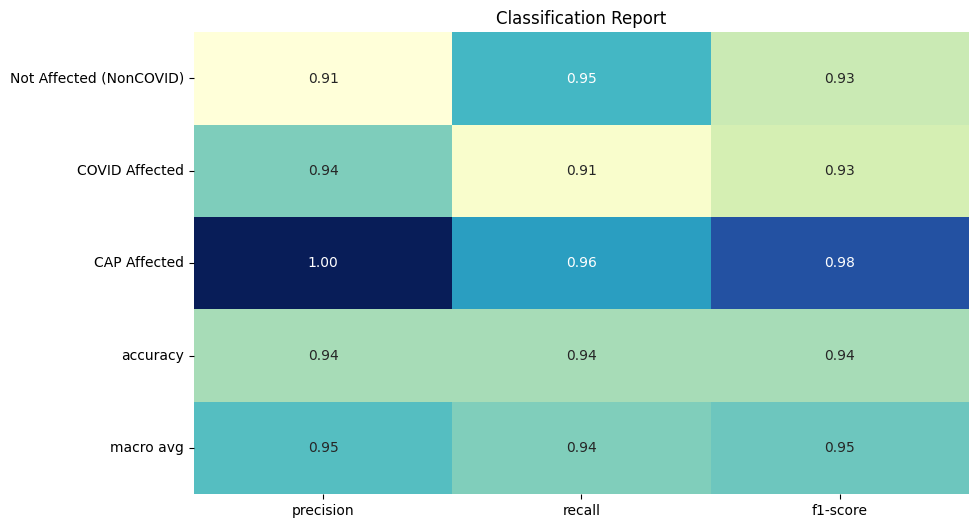

In [ ]:
plot_classification_report(y_test, predictions, class_names)


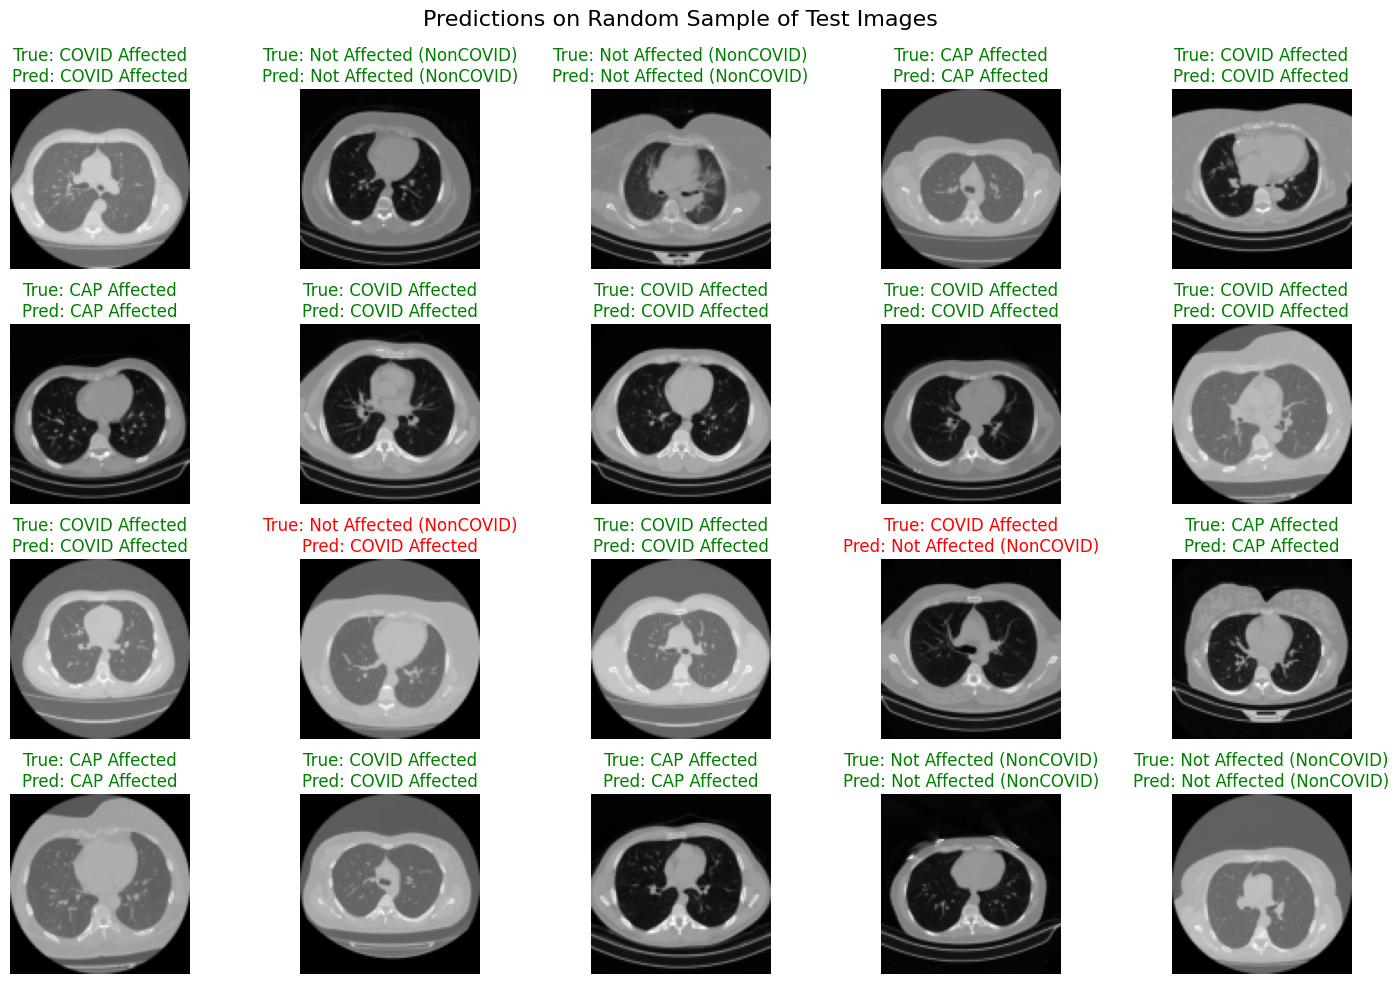

In [ ]:
import matplotlib.pyplot as plt

# Define class names for display purposes
class_names = ["Not Affected (NonCOVID)", "COVID Affected", "CAP Affected"]

# Display 20 random test images with their true and predicted labels
def display_predictions(original_images, y_test, predictions, class_names, test_indices, num_images=20):
    plt.figure(figsize=(15, 10))
    indices = np.random.choice(len(y_test), num_images, replace=False)

    for i, idx in enumerate(indices):
        img_index = test_indices[idx]  # Get the original index of the image
        img = original_images[img_index]  # Retrieve the original image from the full dataset
        plt.subplot(4, 5, i + 1)  # Create a 4x5 grid for 20 images
        plt.imshow(img, cmap='gray')

        true_label = class_names[y_test[idx]]
        predicted_label = class_names[predictions[idx]]
        color = "green" if y_test[idx] == predictions[idx] else "red"  # Green if correct, red if incorrect

        plt.title(f"True: {true_label}\nPred: {predicted_label}", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle('Predictions on Random Sample of Test Images', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

# Split the data and keep track of the test indices for the original images
images, labels = load_images_from_folder(data_folder)
train_images, test_images, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Transform test_images into HOG features for prediction
hog_test_features = [hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                         transform_sqrt=True, block_norm='L2-Hys') for img in test_images]
X_test = np.array(hog_test_features)

# Predict using the Random Forest model
predictions = random_forest_classifier.predict(X_test)

# Display predictions with the original images
display_predictions(images, y_test, predictions, class_names, test_indices=np.arange(len(test_images)), num_images=20)


In [ ]:
from lime import lime_image
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from skimage import io, color, transform
from skimage.color import rgb2gray, gray2rgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import os
import numpy as np

# Function to load and preprocess images from folders
def load_images_from_folder(folder):
    images = []
    labels = []
    for label, label_folder in enumerate(['1NonCOVID', '2COVID', '3CAP']):
        path = os.path.join(folder, label_folder)
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = io.imread(img_path, as_gray=True)  # Read images as grayscale
            if img is not None:
                img = transform.resize(img, (100, 100))  # Resize images to a consistent size
                images.append(img)
                labels.append(label)  # Assigning labels based on folder names
    return images, labels

# Load images and labels
data_folder = '/content/drive/MyDrive/transfer-learning-covid-19-vgg19'  # Replace this with data folder path
images, labels = load_images_from_folder(data_folder)

# Convert images to HOG features
hog_features = []
for image in images:
    # Extract HOG features
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    hog_features.append(features)

# Convert the lists to numpy arrays
X = np.array(hog_features)
y = np.array(labels)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # adjust the number of trees (n_estimators) and other parameters here

# Training the model
random_forest_classifier.fit(X_train, y_train)

# Predicting on the test set
predictions = random_forest_classifier.predict(X_test)

# Calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

# Getting detailed metrics
print(classification_report(y_test, predictions))

# Function to predict the probabilities for the given HOG features
def predict_proba_hog(image):
    # Convert the image to grayscale if it has multiple channels
    if image.ndim == 3:
        image = rgb2gray(image)
    # Extract HOG features for the input image
    features = hog(image, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), transform_sqrt=True, block_norm='L2-Hys')
    features = np.array([features])
    return random_forest_classifier.predict_proba(features)

# Wrapper function to preprocess the image and then predict
def preprocess_and_predict(image):
    # Ensure the image is in grayscale and reshape for predict_proba_hog
    image = rgb2gray(image)
    return predict_proba_hog(image)

# Convert the grayscale images to 3-channel grayscale images
images_rgb = [gray2rgb(image) for image in images]

# Create a LIME image explainer
explainer = lime_image.LimeImageExplainer()

# Explain a prediction
idx = 0  # Index of the image you want to explain
explanation = explainer.explain_instance(images_rgb[idx], preprocess_and_predict, top_labels=3, hide_color=0, num_samples=1000)

# Show the explanation for the top class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry = cv2.bitwise_and(temp, temp, mask=mask)

plt.imshow(img_boundry)
plt.title('LIME Explanation')
plt.axis('off')
plt.show()


Accuracy: 0.94
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      1395
           1       0.94      0.91      0.93      1514
           2       1.00      0.96      0.98       525

    accuracy                           0.94      3434
   macro avg       0.95      0.94      0.95      3434
weighted avg       0.94      0.94      0.94      3434



  0%|          | 0/1000 [00:00<?, ?it/s]

ValueError: the input array must have size 3 along `channel_axis`, got (10, 100, 100)